# 🤖 Student Success Modeling Scaffold
This notebook will guide you through building both a classification and regression model using the cleaned dataset.

**Classification Goal**: Predict if a student will pass or fail.
**Regression Goal**: Predict the student’s final numeric score.

## Step 1: Load Blended Dataset

In [1]:
# TODO: Load the merged CSV file
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, mean_squared_error, r2_score, confusion_matrix
import matplotlib.pyplot as plt

df = pd.read_csv('student_success_blended_lowercase.csv')
# df = pd.read_csv('updated_with_scores.csv')

## Step 2: Prepare Features and Targets

In [2]:
# TODO: Choose predictors and prepare targets for classification and regression

# Changing from string to int values
df_full = df.copy()

# Создаём бинарный таргет заранее
df_full["final_result_clean"] = df_full["final_result"].str.strip().str.lower()
df_full["target_pass"] = df_full["final_result_clean"].apply(lambda x: 1 if x == "pass" else 0)
df_full = df_full.drop(columns=["final_result","final_result_clean"])

# Cols which can cause leaking for Classification
remove_cols_clf = [
    "final_result",       # Classification target
    "target_pass",        # Classification target
    
]
# Cols which can cause leaking for Regression
remove_cols_reg = [
    "avg_assessment_score" # Regression target
]

# Categorical cols if we would like to use some of them
categorical_cols = [
    'gender',
    'region',
    'highest_education',
    'imd_band',
    'age_band',
    'disability',
    'module',
    'presentation'
]

# Numeric features
numeric_features = [
    'assessments_attempted',
    "avg_assessment_score",
    'total_clicks',
    'active_days',
    'studied_credits',
    'num_of_prev_attempts',
]

combined = numeric_features + categorical_cols

# One-hot encoding for Categorical
df_encoded = pd.get_dummies(df_full, columns=categorical_cols, drop_first=True).astype(int)

# Classification
X_clf = df_full[numeric_features] # only numerical features
y_clf = df_full["target_pass"] 

# Features to test a contribution for LinearRegression
selected_features = [
    ## Behavioral
    'assessments_attempted',
    'active_days',

    ## Socio-economic
    'imd_band_30-40%', 'imd_band_40-50%', 'imd_band_50-60%',
    'imd_band_60-70%', 'imd_band_70-80%', 'imd_band_80-90%',
    'imd_band_90-100%',

    ## Education level
    'highest_education_Post Graduate Qualification',
    'highest_education_HE Qualification',
    'highest_education_Lower Than A Level',

    ## Disability
    'disability_Y',

    ## Module (course factor)
    'module_GGG', 'module_BBB', 'module_EEE', 'module_FFF',

    ## Presentation (semester factor)
    'presentation_2013J', 'presentation_2014J'
]

# New features to improve the LR performance
reg_features = [

    # Behavioral
    'assessments_attempted',
    'active_days',
    'total_clicks',
    'studied_credits',
]

#Regression
y_reg = df_full["avg_assessment_score"]
X_reg = df_encoded[selected_features]



## Step 2.1: Feature Engineering for Score prediction

In [3]:
# Engagement & intensity features
df_full["clicks_per_day"] = df_full["total_clicks"] / (df_full["active_days"] + 1)
df_full["attempts_per_day"] = df_full["assessments_attempted"] / (df_full["active_days"] + 1)

# Efficiency features
df_full["clicks_per_credit"] = df_full["total_clicks"] / (df_full["studied_credits"] + 1)
df_full["clicks_per_attempt"] = df_full["total_clicks"] / (df_full["assessments_attempted"] + 1)

# Consistency & pressure features
df_full["attempts_per_active_day"] = df_full["assessments_attempted"] / (df_full["active_days"] + 1)
df_full["active_days_ratio"] = df_full["active_days"] / (df_full["studied_credits"] + 1)

# Interaction features
df_full["engagement_score"] = df_full["clicks_per_day"] * df_full["active_days"]
df_full["assessment_pressure"] = df_full["attempts_per_day"] * df_full["assessments_attempted"]

new_selected_features = [
    ## -------------------------
    ## Behavioral (original)
    ## -------------------------
    'assessments_attempted',
    'active_days',

    ## -------------------------
    ## Engineered behavioral / efficiency features (NEW)
    ## -------------------------
    'clicks_per_day',
    'attempts_per_day',
    'clicks_per_credit',
    'clicks_per_attempt',
    'attempts_per_active_day',
    'active_days_ratio',
    'engagement_score',
    'assessment_pressure',

    ## -------------------------
    ## Socio-economic
    ## -------------------------
    'imd_band_30-40%', 'imd_band_40-50%', 'imd_band_50-60%',
    'imd_band_60-70%', 'imd_band_70-80%', 'imd_band_80-90%',
    'imd_band_90-100%',

    ## -------------------------
    ## Education level
    ## -------------------------
    'highest_education_Post Graduate Qualification',
    'highest_education_HE Qualification',
    'highest_education_Lower Than A Level',

    ## -------------------------
    ## Disability
    ## -------------------------
    'disability_Y',

    ## -------------------------
    ## Module (course factor)
    ## -------------------------
    'module_GGG', 'module_BBB', 'module_EEE', 'module_FFF',

    ## -------------------------
    ## Presentation (semester factor)
    ## -------------------------
    'presentation_2013J', 'presentation_2014J'
]


df_encoded = pd.get_dummies(df_full, columns=categorical_cols, drop_first=True).astype(int)
X_reg = df_encoded[new_selected_features]

X_reg.head()
X_reg.columns.tolist()


['assessments_attempted',
 'active_days',
 'clicks_per_day',
 'attempts_per_day',
 'clicks_per_credit',
 'clicks_per_attempt',
 'attempts_per_active_day',
 'active_days_ratio',
 'engagement_score',
 'assessment_pressure',
 'imd_band_30-40%',
 'imd_band_40-50%',
 'imd_band_50-60%',
 'imd_band_60-70%',
 'imd_band_70-80%',
 'imd_band_80-90%',
 'imd_band_90-100%',
 'highest_education_Post Graduate Qualification',
 'highest_education_HE Qualification',
 'highest_education_Lower Than A Level',
 'disability_Y',
 'module_GGG',
 'module_BBB',
 'module_EEE',
 'module_FFF',
 'presentation_2013J',
 'presentation_2014J']

## Step 2.2: OLS Model After Feature Encoding

In [4]:
X = df_encoded[new_selected_features]
X = sm.add_constant(X)

model = sm.OLS(y_reg, X).fit()
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     avg_assessment_score   R-squared:                       0.255
Model:                              OLS   Adj. R-squared:                  0.254
Method:                   Least Squares   F-statistic:                     339.2
Date:                  Wed, 17 Dec 2025   Prob (F-statistic):               0.00
Time:                          14:09:28   Log-Likelihood:            -1.0481e+05
No. Observations:                 25770   AIC:                         2.097e+05
Df Residuals:                     25743   BIC:                         2.099e+05
Df Model:                            26                                         
Covariance Type:              nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

## 🔍 Step 3: Definition Logistic Regression and Random Forest Classifier (Classification)

In [5]:
def train_model(model_type, X, y):
    """
    model_type: 'RF' for RandomForest, 'LR' for Logistic Regression
    """

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Choose model Logistic Regression or RandomForest
    if model_type == "RF":
        model = RandomForestClassifier(
            n_estimators=300,
            max_depth=12,
            random_state=42
        )
    elif model_type == "LR":
        model = LogisticRegression(
            max_iter=10000
        )
    else:
        raise ValueError("model_type must be 'RF' or 'LR'")

    # Train
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred)

    # Return everything
    return {
        "model": model,
        "accuracy": accuracy,
        "auc": auc,
        "report": report,
        "y_test": y_test,
        "y_prob": y_prob,
    }

## 🔍 Step 4: Train Logistic Regression (Classification)

Accuracy: 0.7050834303453628
ROC AUC: 0.7773847056678457


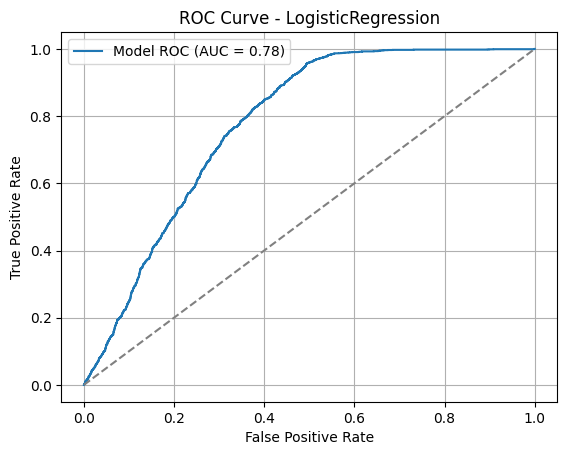

In [6]:
result_lr = train_model("LR", X_clf, y_clf)

y_test_lr = result_lr["y_test"]
y_prob_lr = result_lr["y_prob"]
accuracy_lr = result_lr["accuracy"]
auc_lr = result_lr["auc"]

fpr, tpr, _ = roc_curve(y_test_lr, y_prob_lr)

# ROC Curve Visualization
print("Accuracy:", accuracy_lr)
print("ROC AUC:", auc_lr)

plt.plot(fpr, tpr, label=f"Model ROC (AUC = {auc_lr:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LogisticRegression")
plt.grid()
plt.legend()
plt.show()

## 🔍 Step 5: Train Random Forest Classifier (Pass/Fail Prediction)

Accuracy: 0.7871556072953046
ROC AUC: 0.8719236128636512


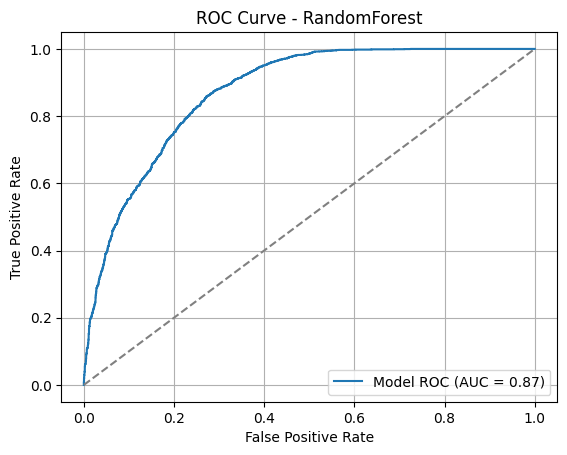

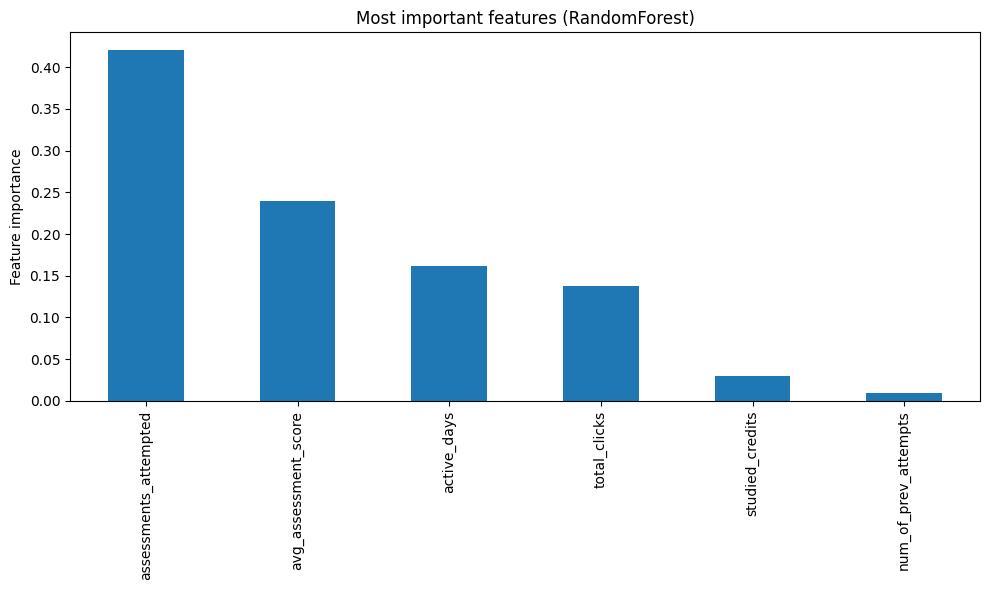

assessments_attempted    0.420697
avg_assessment_score     0.239237
active_days              0.161936
total_clicks             0.138282
studied_credits          0.029968
num_of_prev_attempts     0.009879
dtype: float64


In [7]:
result_rf = train_model("RF", X_clf, y_clf)
rf_model = result_rf["model"]

y_test_rf = result_rf["y_test"]
y_prob_rf = result_rf["y_prob"]
accuracy_rf = result_rf["accuracy"]
auc_rf = result_rf["auc"]

fpr, tpr, _ = roc_curve(y_test_rf, y_prob_rf)

# ROC Curve Visualization
print("Accuracy:", accuracy_rf)
print("ROC AUC:", auc_rf)

plt.plot(fpr, tpr, label=f"Model ROC (AUC = {auc_rf:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - RandomForest")
plt.grid()
plt.legend()
plt.show()

# Feature Importance Visualization
importances = pd.Series(
    rf_model.feature_importances_,
    index=X_clf.columns
).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
importances.head(15).plot(kind="bar")
plt.ylabel("Feature importance")
plt.title("Most important features (RandomForest)")
plt.tight_layout()
plt.savefig("rf_feature_importance.png", dpi=300)
plt.show()

print(importances.head(30))

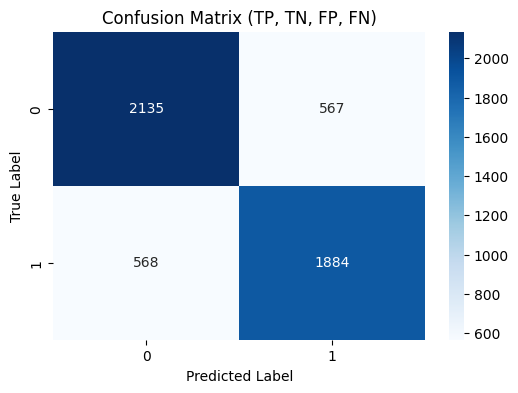

In [8]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_test_rf, (y_prob_rf >= 0.6).astype(int))

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (TP, TN, FP, FN)")
plt.show()

## 5.1 Partial Dependence Plots (Random Forest)”

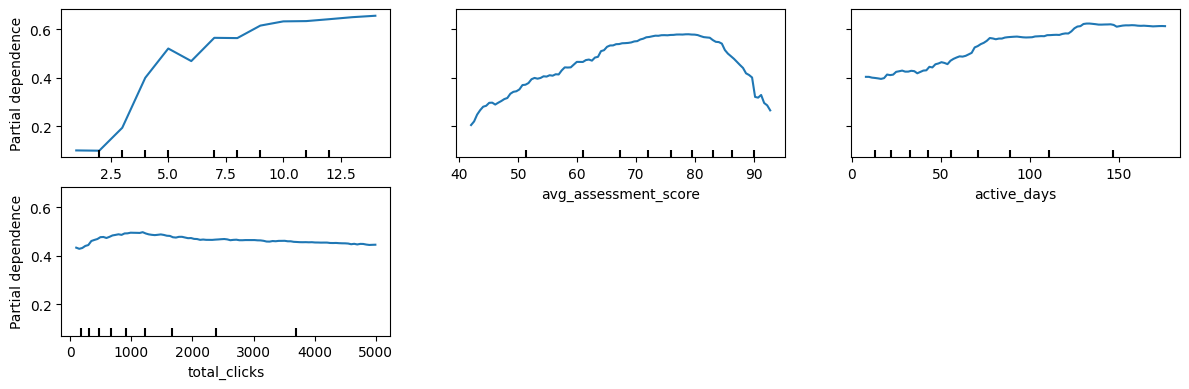

In [9]:
features_for_pdp = [
    "assessments_attempted",
    "avg_assessment_score",
    "active_days",
    "total_clicks"
]

fig, ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(
    rf_model,
    X_clf,
    features_for_pdp,
    ax=ax
)
plt.tight_layout()
plt.savefig("pdp_rf.png", dpi=300)
plt.show()

## Step 6: Train Linear Regression (Score Prediction)

In [10]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

model_reg = LinearRegression()
model_reg.fit(X_train_r, y_train_r)

y_pred_r = model_reg.predict(X_test_r)

model_reg.coef_

list(X_reg.columns)

X_reg.iloc[14]

assessments_attempted                              2
active_days                                       11
clicks_per_day                                    14
attempts_per_day                                   0
clicks_per_credit                                  2
clicks_per_attempt                                57
attempts_per_active_day                            0
active_days_ratio                                  0
engagement_score                                 156
assessment_pressure                                0
imd_band_30-40%                                    0
imd_band_40-50%                                    0
imd_band_50-60%                                    0
imd_band_60-70%                                    0
imd_band_70-80%                                    1
imd_band_80-90%                                    0
imd_band_90-100%                                   0
highest_education_Post Graduate Qualification      0
highest_education_HE Qualification            

## Step 7: Evaluation Metrics for Linear Regression (Score Prediction)

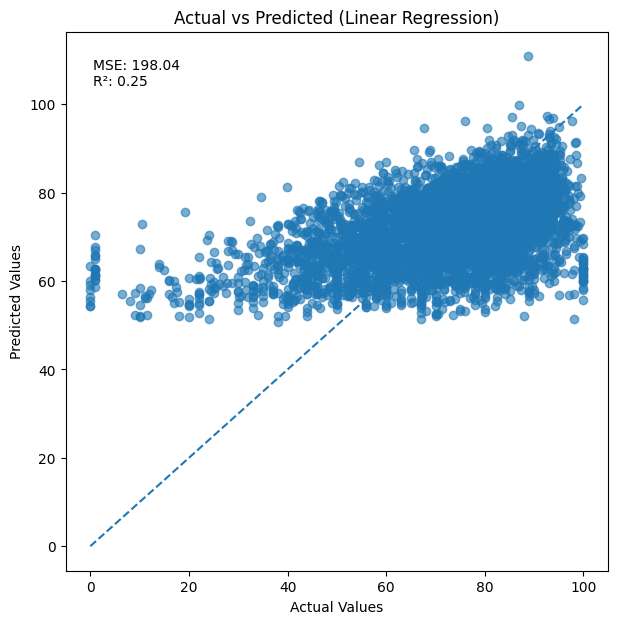

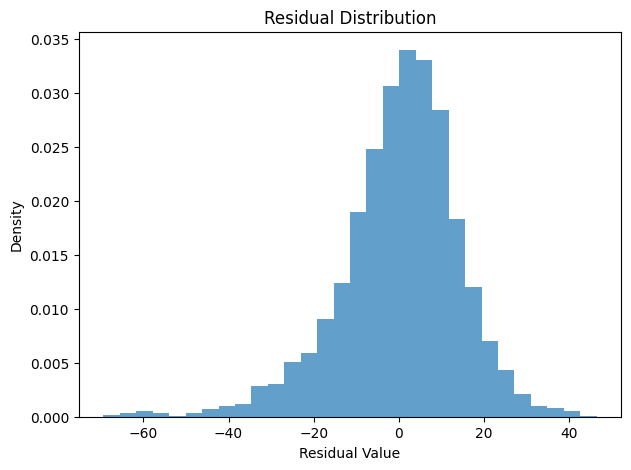

MSE: 198.0418379666176
R²: 0.25251632529775614


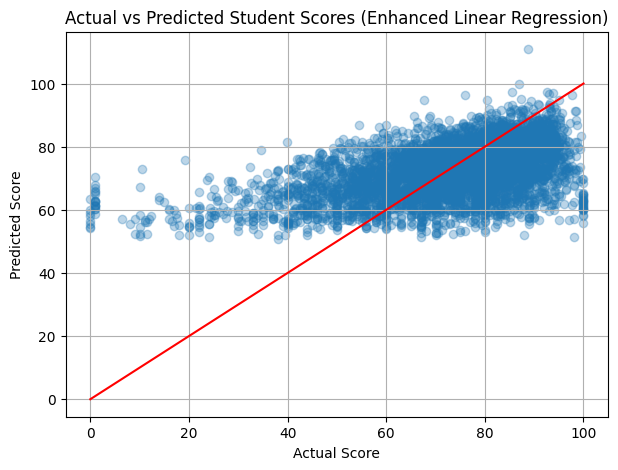


TOP INFLUENTIAL FEATURES:
                                          feature  coefficient
21                                     module_GGG    12.886521
23                                     module_EEE    12.540931
17  highest_education_Post Graduate Qualification     8.107645
22                                     module_BBB     7.672301
24                                     module_FFF     5.208681
15                                imd_band_80-90%     3.042075
16                               imd_band_90-100%     2.965116
3                                attempts_per_day     2.356307
6                         attempts_per_active_day     2.356307
14                                imd_band_70-80%     2.002329

NEGATIVE INFLUENTIAL FEATURES:
                                 feature  coefficient
26                    presentation_2014J     0.643389
1                            active_days     0.087700
2                         clicks_per_day     0.079593
4                      clicks_pe

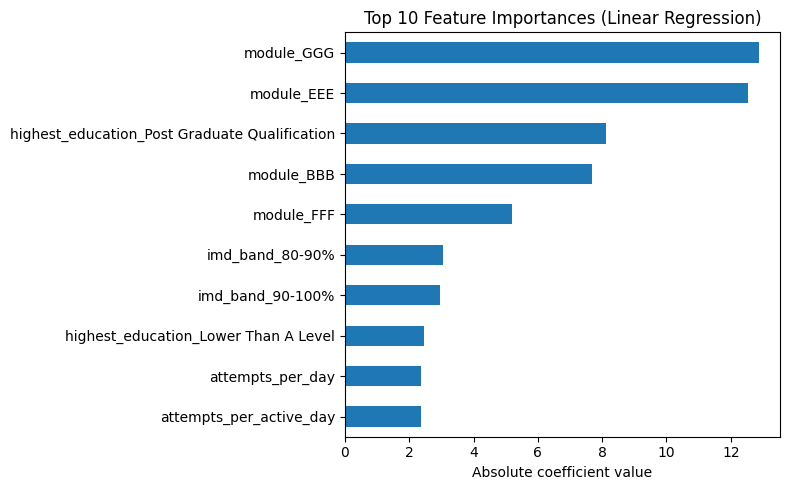

In [11]:
# Metrics
mse = mean_squared_error(y_test_r, y_pred_r)
r2 = r2_score(y_test_r, y_pred_r)

plt.figure(figsize=(7, 7)) 
plt.scatter(y_test_r, y_pred_r, alpha=0.6) 
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], linestyle='--') 
plt.xlabel("Actual Values") 
plt.ylabel("Predicted Values") 
plt.title("Actual vs Predicted (Linear Regression)") 
plt.text(0.05, 0.95, f"MSE: {mse:.2f}\nR²: {r2:.2f}", transform=plt.gca().transAxes, verticalalignment='top') 
plt.show()

residuals = y_test_r - y_pred_r

plt.figure(figsize=(7, 5))
plt.hist(residuals, bins=30, alpha=0.7, density=True)

plt.xlabel("Residual Value")
plt.ylabel("Density")
plt.title("Residual Distribution")

plt.show()

print("MSE:", mse)
print("R²:", r2)

plt.figure(figsize=(7,5))
plt.scatter(y_test_r, y_pred_r, alpha=0.3)
plt.plot([0,100], [0,100], color='red')
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Actual vs Predicted Student Scores (Enhanced Linear Regression)")
plt.grid()
plt.show()

coeff_df = pd.DataFrame({
    "feature": X_reg.columns,
    "coefficient": model_reg.coef_
}).sort_values(by="coefficient", ascending=False)

print("\nTOP INFLUENTIAL FEATURES:")
print(coeff_df.head(10))
print("\nNEGATIVE INFLUENTIAL FEATURES:")
print(coeff_df.tail(10))

# 1. Get coefficients as a Series and sort by absolute value
lin_imp = pd.Series(
    np.abs(model_reg.coef_),
    index=X_reg.columns
).sort_values(ascending=False)

plt.figure(figsize=(8,5))
lin_imp.head(10).sort_values().plot(kind="barh")
plt.xlabel("Absolute coefficient value")
plt.title("Top 10 Feature Importances (Linear Regression)")
plt.tight_layout()
plt.show()

## Step 8: Train XGBoost (Score Prediction)

In [12]:
xgb_model = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=42
)

xgb_model.fit(X_train_r, y_train_r)

y_pred_r = xgb_model.predict(X_test_r)

## Step 9: Evaluation Metrics for XGBoost

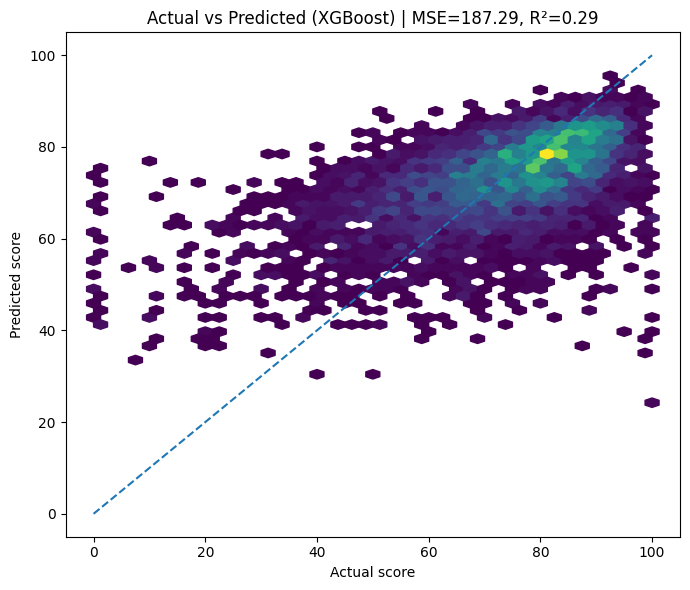

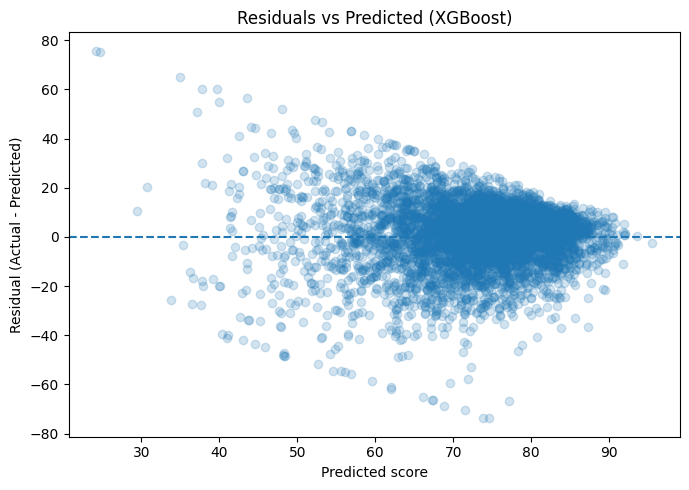

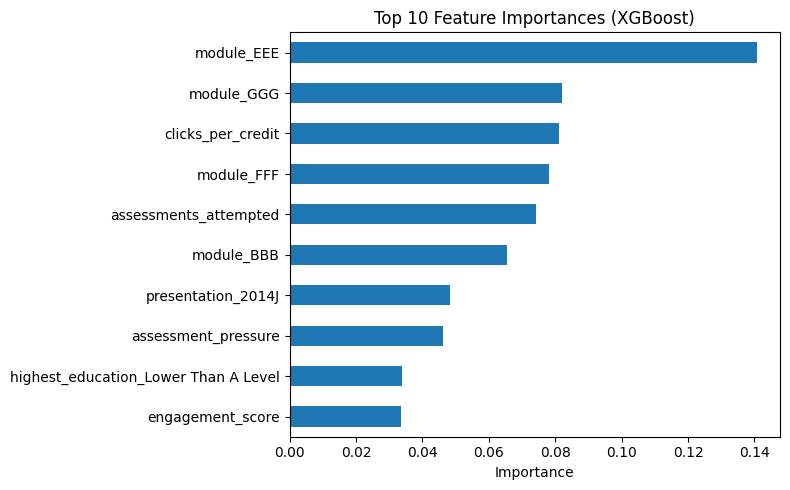

In [13]:
mse = mean_squared_error(y_test_r, y_pred_r)
r2 = r2_score(y_test_r, y_pred_r)

plt.figure(figsize=(7,6))
plt.hexbin(y_test_r, y_pred_r, gridsize=40, mincnt=1)
plt.plot([y_test_r.min(), y_test_r.max()],
         [y_test_r.min(), y_test_r.max()],
         linestyle="--")
plt.xlabel("Actual score")
plt.ylabel("Predicted score")
plt.title(f"Actual vs Predicted (XGBoost) | MSE={mse:.2f}, R²={r2:.2f}")
plt.tight_layout()
plt.show()

residuals = y_test_r - y_pred_r

plt.figure(figsize=(7,5))
plt.scatter(y_pred_r, residuals, alpha=0.2)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted score")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted (XGBoost)")
plt.tight_layout()
plt.show()

imp = pd.Series(xgb_model.feature_importances_, index=X_reg.columns).sort_values(ascending=False)

plt.figure(figsize=(8,5))
imp.head(10).sort_values().plot(kind="barh")
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

## ✅ Step 10: Reflect

# Based on model performance:
1) Across all experiments, the most predictive features were assessment- and performance-related variables.
In particular, features such as:
    1. assessments_attempted
    2. engineered intensity features (e.g., attempts_per_day, assessment_pressure)
    3. module-specific indicators (e.g., module_EEE, module_GGG)

2) A key surprise was that switching from Linear Regression to XGBoost did not lead to a substantial improvement when using the same raw feature set.
Although XGBoost is a more expressive, non-linear model, performance gains were marginal (R² improved only slightly from ~0.25 to ~0.27).
This indicates that model choice alone is not sufficient when the input data lacks strong performance-related signals.
Feature expansion improved interpretability and helped highlight meaningful patterns, but overall predictive gains remained limited.

3) The results suggest that the primary limitation lies in the data itself, not the algorithms.
To improve predictive performance, the model would benefit from additional, more informative data such as:
    1. Individual assessment and exam scores (rather than aggregated averages)
    2. Temporal progression data (early vs late semester performance trends)
    3. Submission timing (late vs on-time submissions)
    4. Assessment difficulty or weighting
    5. Instructor feedback or grading rubrics
    6.Attendance in live sessions or labs
Including richer, time-aware academic performance data would likely allow both linear and non-linear models to better capture 
student learning dynamics and significantly improve score prediction.